# Extract #

In [69]:
import requests
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error
import seaborn as sns


In [45]:
# URL of the webpage to extract data from
url = 'https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_nus_dpg&f=w'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the webpage
    tables = pd.read_html(response.content)
    
    # Check if any tables were found
    if tables:
        # Assuming you want to extract data from the sixth table
        df = tables[5]


In [46]:
df.tail()

Year-Month   Week 1          Week 2          Week 3          Week 4  \
    Year-Month End Date  Value End Date  Value End Date  Value End Date   
404   2024-May    05/06  3.766    05/13  3.731    05/20  3.706    05/27   
405   2024-Jun    06/03  3.638    06/10  3.551    06/17  3.556    06/24   
406   2024-Jul    07/01  3.595    07/08  3.608    07/15  3.614    07/22   
407   2024-Aug    08/05  3.563    08/12  3.530    08/19  3.500    08/26   
408   2024-Sep    09/02  3.411      NaN    NaN      NaN    NaN      NaN   

             Week 5        Unnamed: 11_level_0 Unnamed: 12_level_0  
     Value End Date  Value Unnamed: 11_level_1 Unnamed: 12_level_1  
404  3.698      NaN    NaN                 NaN                 NaN  
405  3.557      NaN    NaN                 NaN                 NaN  
406  3.587    07/29  3.598                 NaN                 NaN  
407  3.433      NaN    NaN                 NaN                 NaN  
408    NaN      NaN    NaN                 NaN                 NaN

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   (Year-Month, Year-Month)                    378 non-null    object 
 1   (Week 1, End Date)                          378 non-null    object 
 2   (Week 1, Value)                             378 non-null    float64
 3   (Week 2, End Date)                          377 non-null    object 
 4   (Week 2, Value)                             377 non-null    float64
 5   (Week 3, End Date)                          377 non-null    object 
 6   (Week 3, Value)                             377 non-null    float64
 7   (Week 4, End Date)                          377 non-null    object 
 8   (Week 4, Value)                             377 non-null    float64
 9   (Week 5, End Date)                          131 non-null    object 
 10  (Week 5, Value

# Transform #

In [47]:
# Create an empty list to store the pairs of Week, Value, and Year-Month with their corresponding values
week_value_month_pairs = []

# Iterate over the rows of the DataFrame
for _, row in df.iterrows():
    # Iterate over the MultiIndex levels and their values in each row
    for (level_0, level_1), value in zip(df.columns, row):
        # Check if the levels contain "Week", "Value", and "Year-Month"
        if 'Week' in level_0 and 'Value' in level_1:
            # Extract the Week, Value, and Year-Month with their corresponding values
            week_value_month_pairs.append((row[('Year-Month', 'Year-Month')], row[(level_0, 'End Date')], value))

# Create DataFrame from the list of pairs
df_pairs = pd.DataFrame(week_value_month_pairs, columns=['Year-Month', 'Week', 'Value'])


In [48]:
df_pairs.tail()

,Year-Month,Week,Value
2040,2024-Sep,09/02,3.411
2041,2024-Sep,NaN,NaN
2042,2024-Sep,NaN,NaN
2043,2024-Sep,NaN,NaN
2044,2024-Sep,NaN,NaN


In [51]:
df_pairs["date"] = df_pairs['Year-Month'].str[:4] + "/" + df_pairs["Week"]
df_pairs.drop(columns = ["Year-Month", "Week"], inplace=True)
df = df_pairs.dropna().set_index("date")
df.head()


,Value
date,
1993/04/05,1.068
1993/04/12,1.079
1993/04/19,1.079
1993/04/26,1.086
1993/05/03,1.086


In [52]:
df.shape

(1640, 1)

## Saving this dataset in my PostgreSQL Server

In [53]:
# PostgreSQL connection parameters
user = 'postgres'
password = 'dataskool'
host = 'localhost'
port = '5432'
database = 'postgres'

# Create a connection engine
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')

# Save the dataframe to PostgreSQL
df.to_sql('weekly_gasoline_price', engine, if_exists='replace', index=True)

# SQL query to select data from your table
query = 'SELECT * FROM weekly_gasoline_price'

# Execute the query and load the result into a pandas DataFrame
df = pd.read_sql(query, engine)
df.set_index('date', inplace=True)

df

,Value
date,
1993/04/05,1.068
1993/04/12,1.079
1993/04/19,1.079
1993/04/26,1.086
1993/05/03,1.086
...,...
2024/08/05,3.563
2024/08/12,3.530
2024/08/19,3.500


In [60]:
def wrangle(df):
    
    # Import the file and set the date as index
    #df =pd.read_csv(filepath).set_index("date")
    
    # Convert the date column as datetime type
    df.index = pd.to_datetime(df.index)
    
    # localize time zone
    #df.index = df.index.tz_localize("UTC").tz_convert("America/Denver")
    
    # Only include weeks when the price was less than 4.5 dollars
    #mask = df["Value"] < 4.5
    #df = df[mask]
    
   
    # Resample to 1W window, forward fill missing values
    y = df["Value"].resample("1W").mean().fillna(method = 'ffill')
    

    
    return y

In [61]:
y = wrangle(df)
print(y.shape)
y.tail()

(1640,)


C:\Users\Usama Pasha\AppData\Local\Temp\ipykernel_8456\2880878085.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df["Value"].resample("1W").mean().fillna(method = 'ffill')


date
2024-08-11    3.563
2024-08-18    3.530
2024-08-25    3.500
2024-09-01    3.433
2024-09-08    3.411
Freq: W-SUN, Name: Value, dtype: float64

In [62]:
print (y.isnull().sum())
print (type(y))

0
<class 'pandas.core.series.Series'>


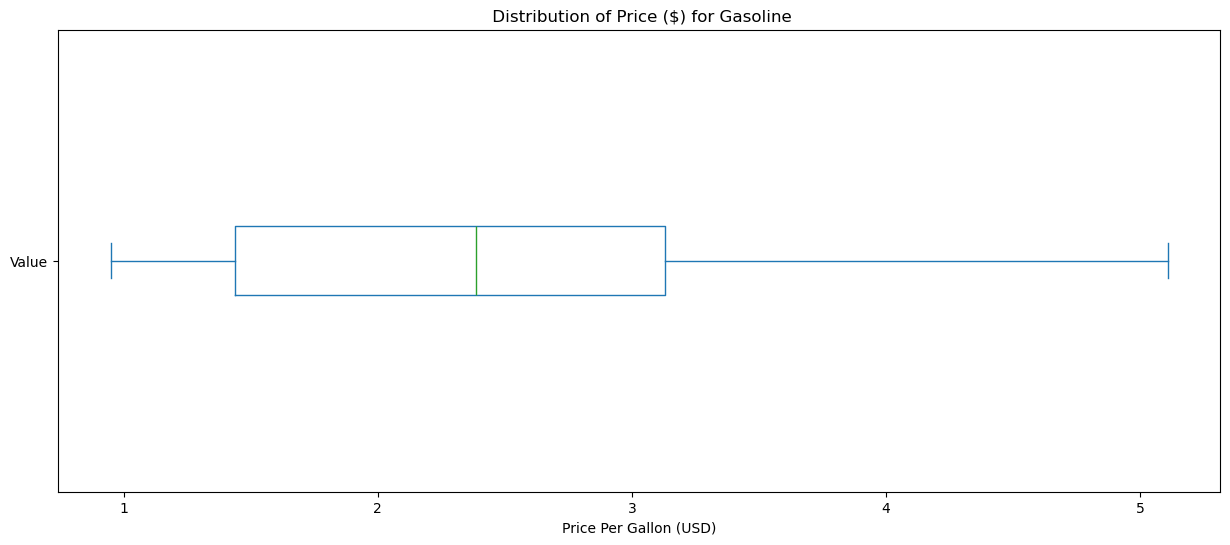

In [65]:
# Creating a boxplot to locate outliers
fig, ax = plt.subplots(figsize=(15,6))
y.plot(kind = "box", vert=False, title= " Distribution of Price ($) for Gasoline", ax=ax)
ax.set_xlabel("Price Per Gallon (USD)");

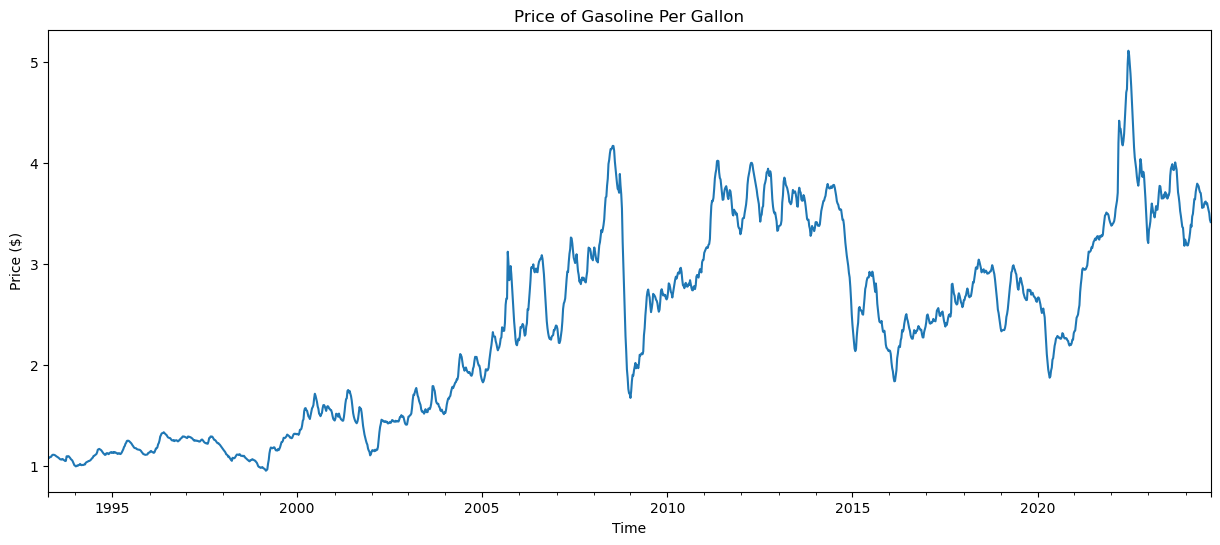

In [66]:
#Creating a time series plot of the Price
fig, ax =plt.subplots(figsize = (15,6))
y.plot(xlabel= "Time", ylabel = "Price ($)", title= "Price of Gasoline Per Gallon", ax=ax);

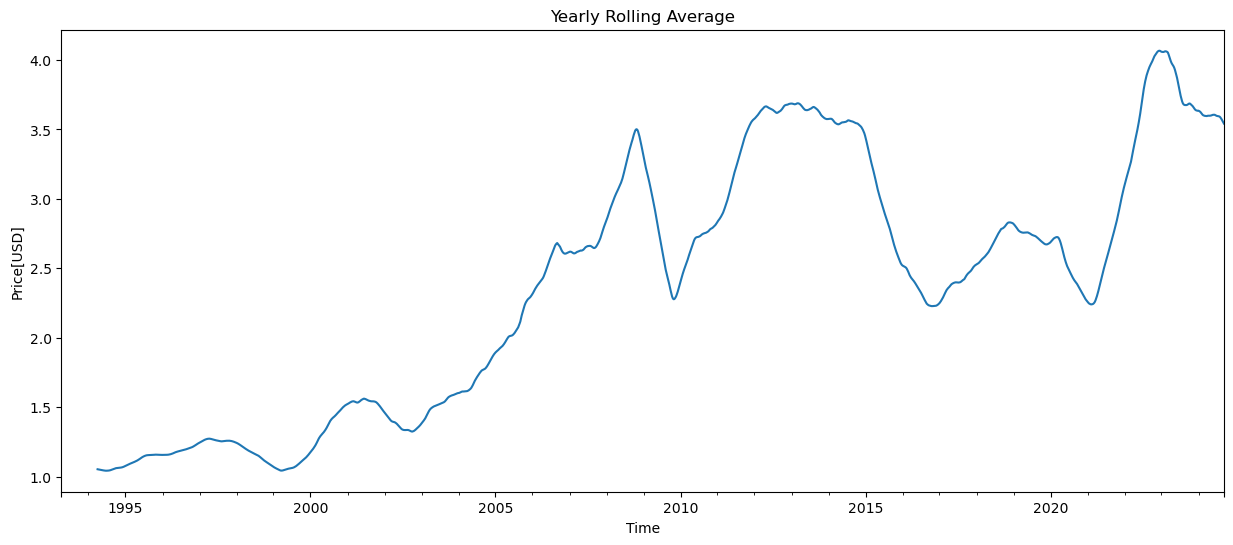

In [67]:
#Creating a time series plot of the Price with a rolling average
fig, ax =plt.subplots(figsize = (15,6))
y.rolling(52).mean().plot(xlabel= "Time", ylabel = "Price[USD]", title= "Yearly Rolling Average", ax=ax);

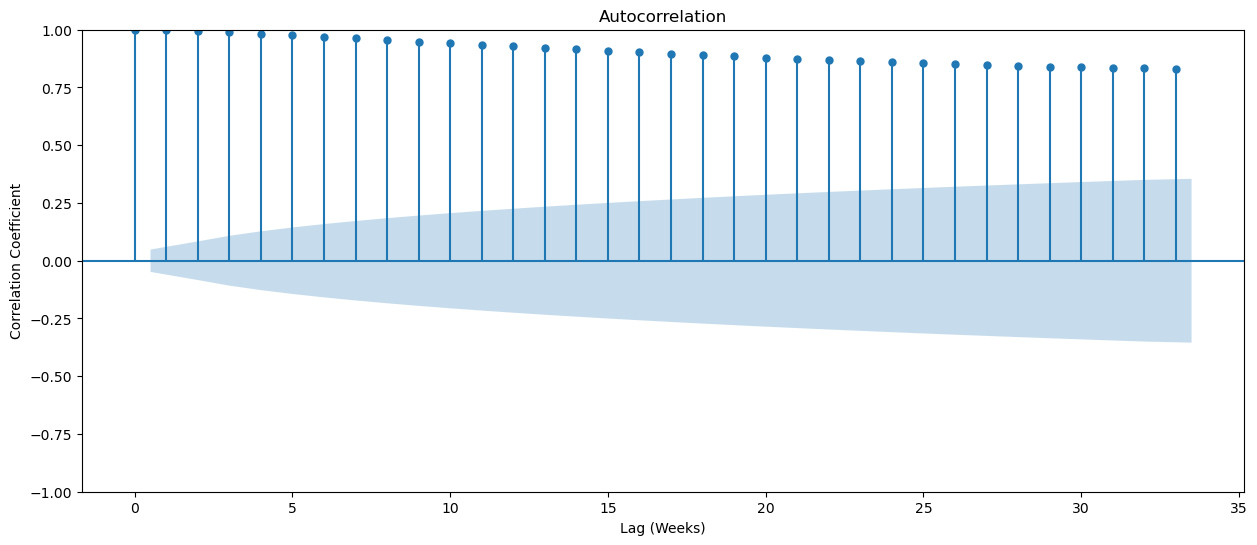

In [70]:
#Create an ACF plot
fig,ax = plt.subplots(figsize = (15,6))
plot_acf(y, ax=ax)

plt.xlabel("Lag (Weeks)")
plt.ylabel("Correlation Coefficient");

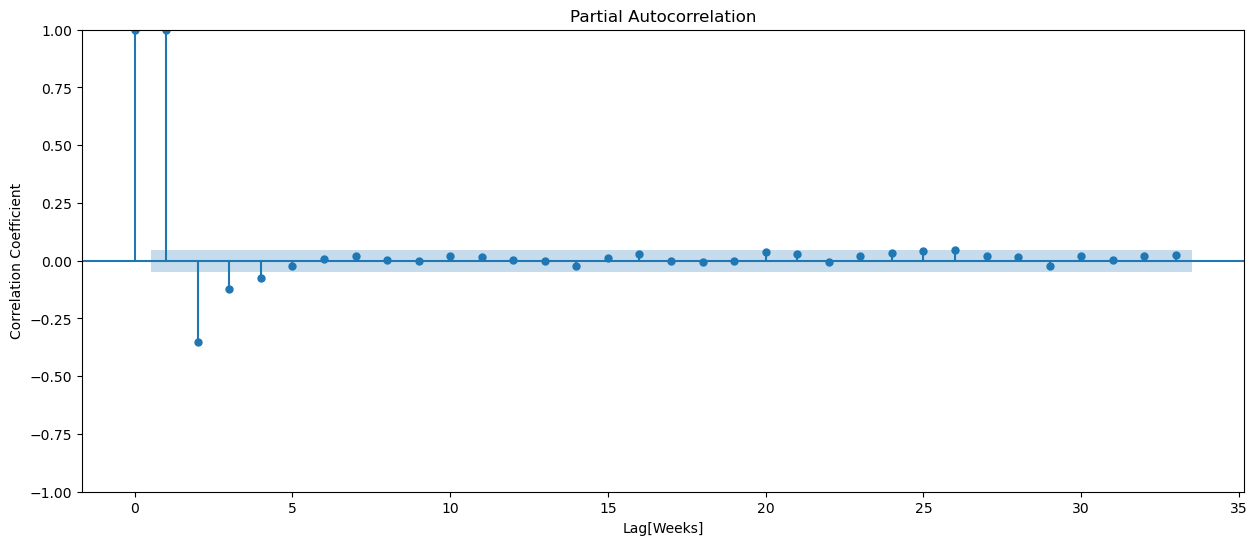

In [71]:
#Create a PACF plot
fig,ax = plt.subplots(figsize = (15,6))
plot_pacf(y, method = 'ywm', ax=ax) 
plt.xlabel("Lag[Weeks]")
plt.ylabel("Correlation Coefficient");

In [72]:
cutoff = int(len(y) * 0.90)
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

In [73]:
#Build a Baseline Model
y_train_mean = y_train.mean()
y_train_pred = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_train_pred)
print("Mean Weekly Price:", round(y_train_mean,2))
print("Error of the Baseline Model (MAE):", round(mae_baseline,2))

Mean Weekly Price: 2.22
Error of the Baseline Model (MAE): 0.76


In [74]:
model = AutoReg(y_train, lags = 4).fit()

In [75]:
model.predict()

date
1993-04-11         NaN
1993-04-18         NaN
1993-04-25         NaN
1993-05-02         NaN
1993-05-09    1.094302
                ...   
2021-06-20    3.130280
2021-06-27    3.176813
2021-07-04    3.148816
2021-07-11    3.202306
2021-07-18    3.229853
Freq: W-SUN, Length: 1476, dtype: float64

In [76]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[4:], y_pred)
print("Error on Training Set (MAE):", round(training_mae, 4))

Error on Training Set (MAE): 0.0247


In [77]:
y_train_resid = model.resid

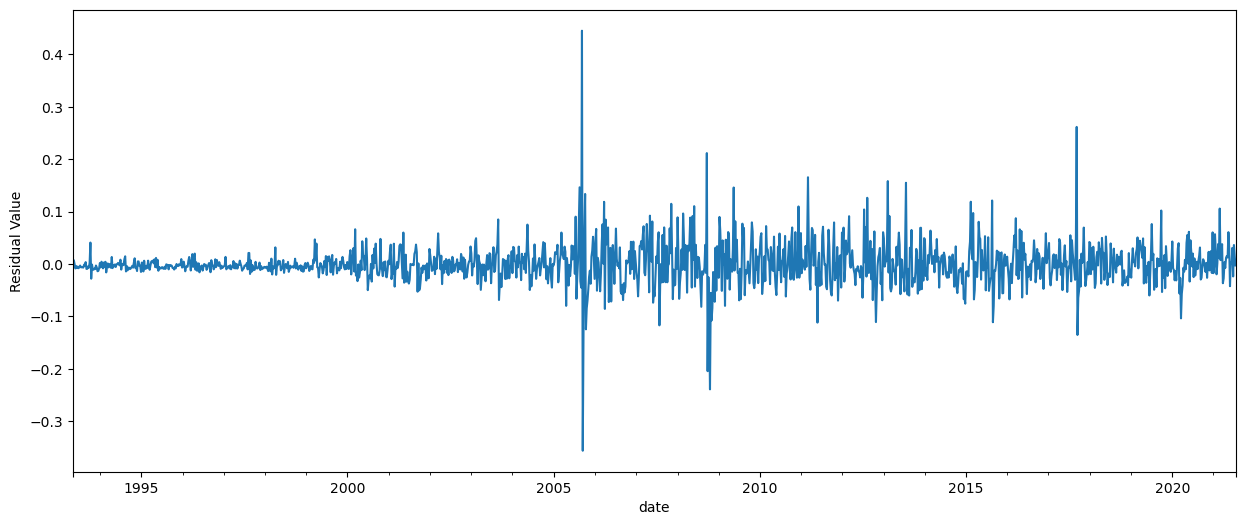

In [78]:
#plotting the residual
fig,ax =plt.subplots(figsize = (15,6))
y_train_resid.plot(ylabel="Residual Value", ax=ax);

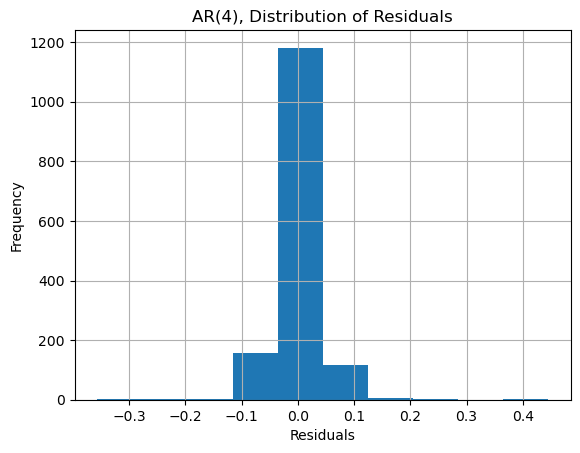

In [79]:
#Plotting the histogram
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("AR(4), Distribution of Residuals");

In [80]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
y_pred_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", y_pred_mae)

Test MAE: 0.7983450443403398


In [81]:
df_pred_test = pd.DataFrame(
{"y_test": y_test, "y_pred" : y_pred_test} , index = y_test.index
)    

In [82]:
df_pred_test.tail()

,y_test,y_pred
date,,
2024-08-11,3.563,2.667220
2024-08-18,3.530,2.665283
2024-08-25,3.500,2.663361
2024-09-01,3.433,2.661454
2024-09-08,3.411,2.659561


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


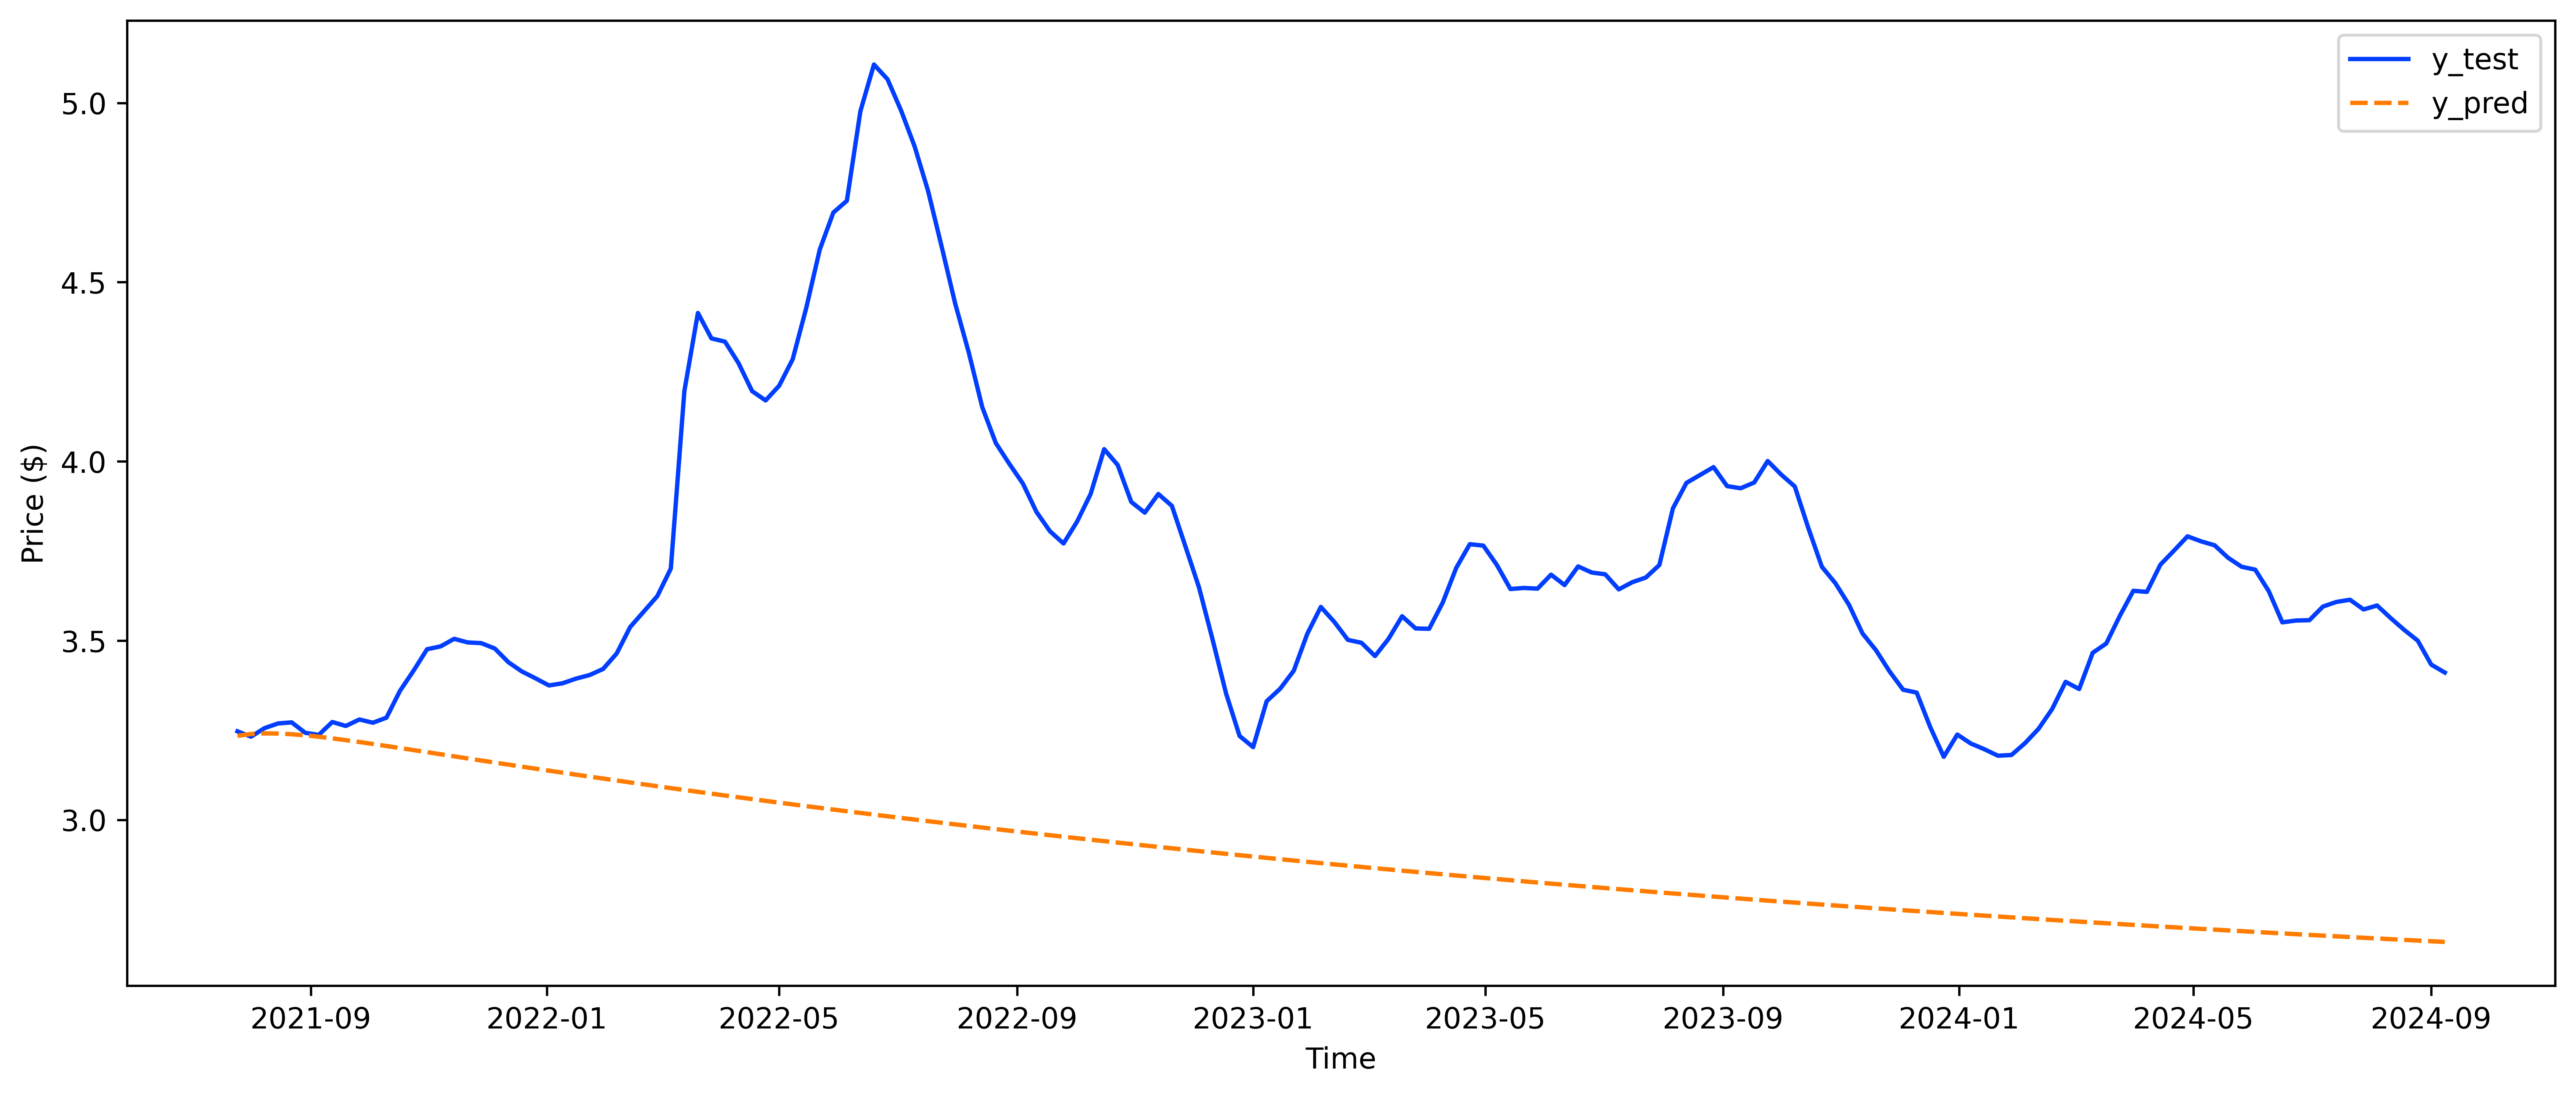

In [83]:
fig, ax =plt.subplots(dpi = 600, figsize = (15,6))
sns.lineplot(data =df_pred_test, palette = 'bright')
plt.xlabel("Time")
plt.ylabel("Price ($)");

In [85]:
y_pred_wfv = pd.Series()  # store our predictions
history = y_train.copy()  # starts with training data, we will keep adding data points from our test set one-by-one
for i in range(len(y_test)):
    model = AutoReg(history, lags = 4).fit()
    next_pred = model.forecast() # create out of sample prediction
    y_pred_wfv = y_pred_wfv._append(next_pred) # appending to a series is little different than appending to a list
    history = history._append(y_test[next_pred.index]) # append the datapoint with the same index as next_pred

C:\Users\Usama Pasha\AppData\Local\Temp\ipykernel_8456\3721819926.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_pred_wfv = y_pred_wfv._append(next_pred) # appending to a series is little different than appending to a list


In [86]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (WALK FORWARD VALIDATION): ", round (test_mae, 4))

Test MAE (WALK FORWARD VALIDATION):  0.0434


In [87]:
print(model.params)

const       0.006936
Value.L1    1.537833
Value.L2   -0.547112
Value.L3    0.103289
Value.L4   -0.096726
dtype: float64


In [88]:
df_pred_wfv_test = pd.DataFrame(
         {"y_test": y_test, "y_pred_wfv": y_pred_wfv} , index=y_test.index
)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


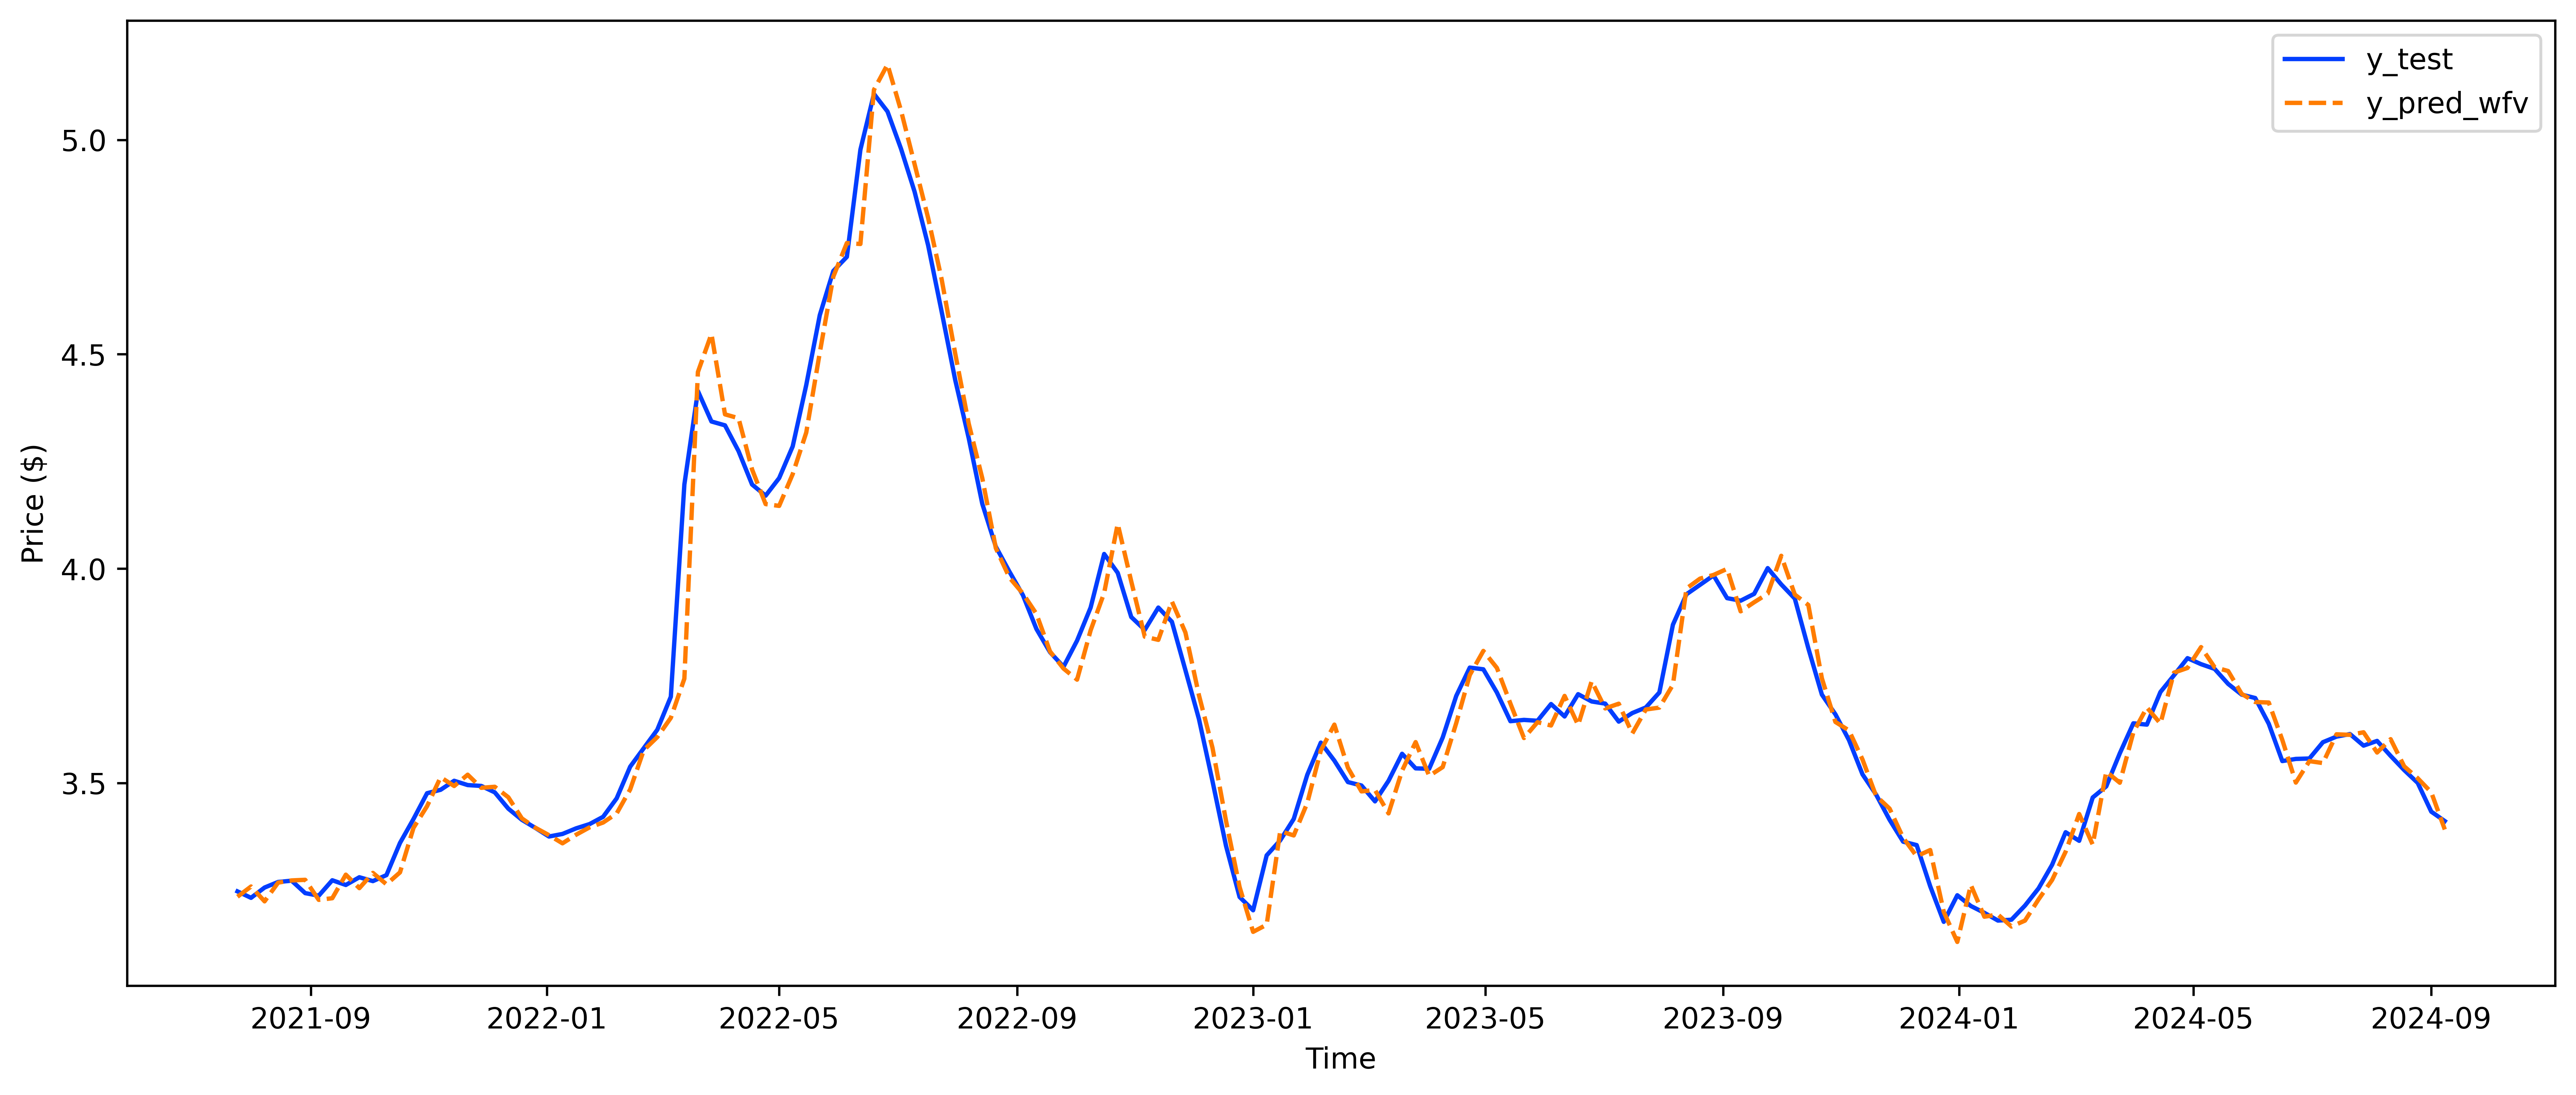

In [89]:
fig, ax =plt.subplots(dpi = 600, figsize = (15,6))
sns.lineplot(data =df_pred_wfv_test, palette = 'bright')
plt.xlabel("Time")
plt.ylabel("Price ($)");